# Training a ML model using CICIoT2023

This notebook shows how a LogisticRegression model can be trained using the CICIoT2023 csv files.

In [12]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import joblib

In [3]:
DATASET_DIRECTORY = ".\Files\\"

XGBoost, LightGBM, CatBoost, Stacking, Baging, Voting
Hyperparameter tuning Bayes
Importance des caratéristiques
Oversampling, undersampling

### Importing Dataset

In [5]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
# print(df_sets[0:10])

# Only use the first 10 datasets
# df_sets = df_sets[0:10]

training_sets = df_sets[:int(len(df_sets)*.8)]
test_sets = df_sets[int(len(df_sets)*.8):]

In [6]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

### Scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()

In [8]:
for train_set in tqdm(training_sets):
    scaler.fit(pd.read_csv(DATASET_DIRECTORY + train_set)[X_columns])

100%|██████████| 135/135 [02:18<00:00,  1.03s/it]


## Performance Evaluation

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_false_positives_and_false_negatives_multiclass_auto(y_true, y_pred):
    """
    Calcule les faux positifs (FP) et les faux négatifs (FN) pour chaque classe dans une classification multiclasse.

    Args:
    - y_true (array-like): Les vraies étiquettes.
    - y_pred (array-like): Les prédictions du modèle.

    Returns:
    - fp_dict (dict): Un dictionnaire contenant les faux positifs par classe.
    - fn_dict (dict): Un dictionnaire contenant les faux négatifs par classe.
    - labels (list): La liste des étiquettes uniques de classe.
    """

    labels = np.unique(np.concatenate([y_true, y_pred]))
    # Créez un dictionnaire pour mapper les étiquettes aux indices entiers
    label_to_index = {label: index for index, label in enumerate(labels)}
    
    fp_dict = {}
    fn_dict = {}

    for label in labels:
        # Mapper l'étiquette à l'indice entier
        label_index = label_to_index[label]

        # Créez une matrice de confusion pour la classe actuelle
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        # Extrayez les valeurs de faux positifs et de faux négatifs pour la classe actuelle
        # print(cm)
        fp = sum(cm[:, label_index]) - cm[label_index, label_index]
        fn = sum(cm[label_index, :]) - cm[label_index, label_index]

        fp_dict[label] = fp
        fn_dict[label] = fn

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(cm)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(25, 18))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return fp_dict, fn_dict

239203
[[   9    1    0 ...    2    0    1]
 [   2 5229   10 ...    2    0    6]
 [   0    6   22 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    5]
 [   0    1    0 ...    0  197    0]
 [   0    1    0 ...    0    0   11]]


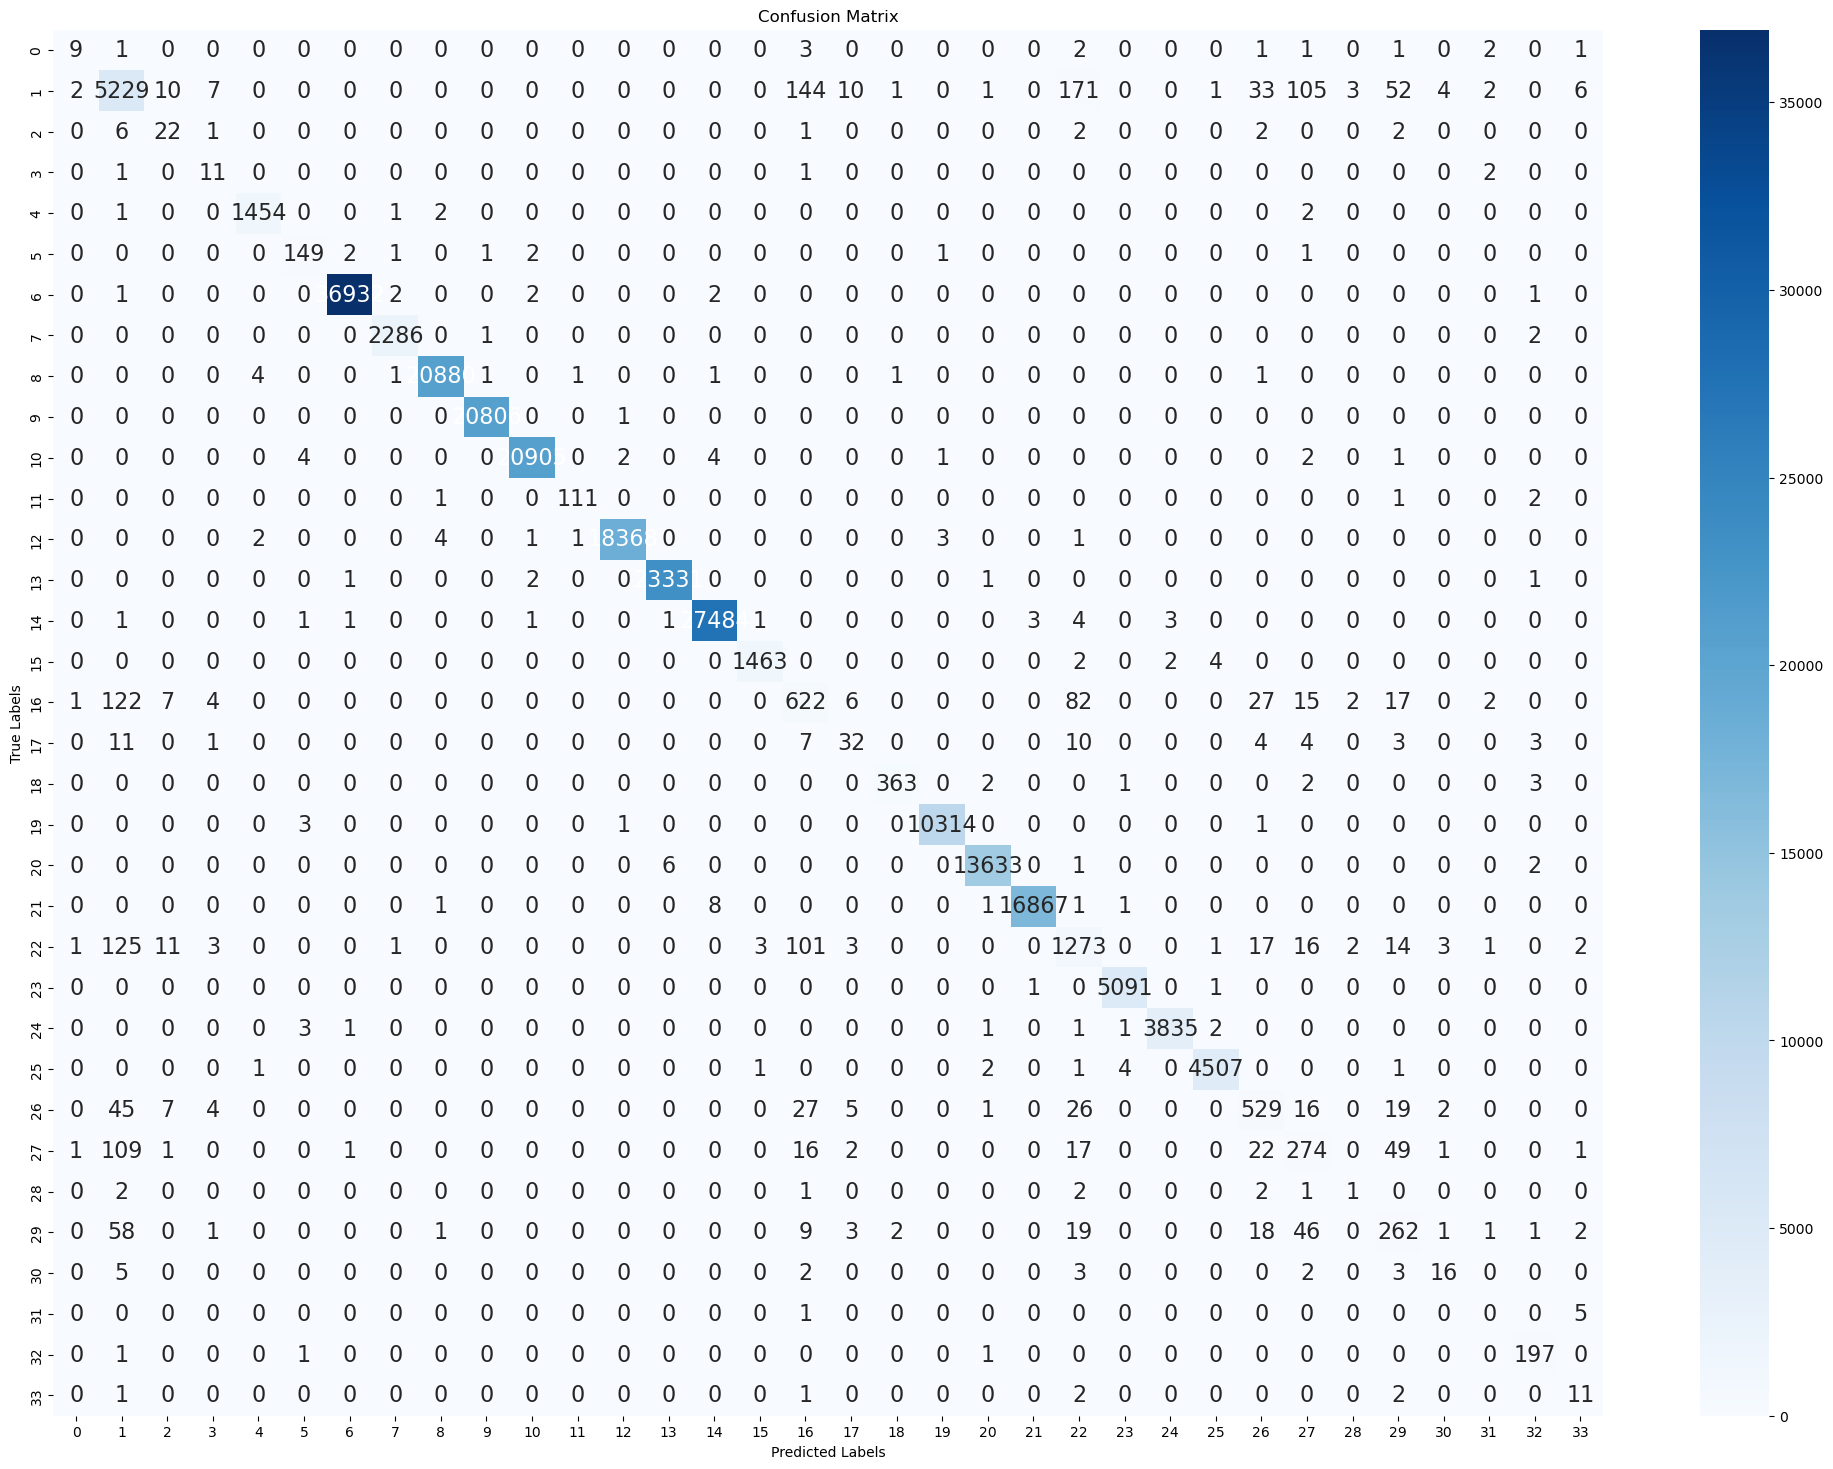

                Category  Count
1          BenignTraffic    490
22      MITM-ArpSpoofing    347
16          DNS_Spoofing    314
27          Recon-OSScan    213
29        Recon-PortScan    165
26   Recon-HostDiscovery    128
2       BrowserHijacking     36
17  DictionaryBruteForce     29
3       CommandInjection     21
33                   XSS     17
32     VulnerabilityScan     15
14        DDoS-UDP_Flood     15
5        DDoS-HTTP_Flood     12
30          SqlInjection     11
31      Uploading_Attack     10
20         DoS-TCP_Flood     10
25        Mirai-udpplain      9
8      DDoS-PSHACK_Flood      9
10        DDoS-SYN_Flood      8
13        DDoS-TCP_Flood      7
1936
                   Category  Count
1             BenignTraffic    552
22         MITM-ArpSpoofing    304
16             DNS_Spoofing    285
27             Recon-OSScan    220
29           Recon-PortScan    162
26      Recon-HostDiscovery    152
17     DictionaryBruteForce     43
14           DDoS-UDP_Flood     16
30      

In [72]:
def singlePerformance(model, modelName, X_test, y_test):
    y_pred = model.predict(X_test)

    fp, fn = calculate_false_positives_and_false_negatives_multiclass_auto(y_test, y_pred)

    return accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro'), fp, fn

# Load the model
model = joblib.load('.\\Models\\model_DecisionTreeClassifier_34_classes.joblib')

# Load the test set
X_test = pd.read_csv(DATASET_DIRECTORY + test_sets[0])[X_columns]
y_test = pd.read_csv(DATASET_DIRECTORY + test_sets[0])[y_column]
# print(X_test[:5])
# print(y_test[:5])
print(len(y_test))

# Scale the test set
X_test = scaler.transform(X_test)

# Get the performance
accuracy, recall, precision, f1, fp, fn = singlePerformance(model, 'DecisionTreeClassifier', X_test, y_test)
performance = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'FP': fp, 'FN': fn}
# print(performance)
# print(fp)

data_fp = {
    'Category': list(fp.keys()),
    'Count': list(fp.values())
}
df_fp = pd.DataFrame(data_fp)
df_fp.sort_values(by=['Count'], inplace=True, ascending=False)

print(df_fp.head(20))
print(df_fp['Count'].sum())

data_fn = {
    'Category': list(fn.keys()),
    'Count': list(fn.values())
}
df_fn = pd.DataFrame(data_fn)
df_fn.sort_values(by=['Count'], inplace=True, ascending=False)

print(df_fn.head(20))
print(df_fn['Count'].sum())

# Classification: 34 (33+1) classes

In [34]:
ML_models = [
        DecisionTreeClassifier(),
        RandomForestClassifier(n_jobs=-1),
        # GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "DecisionTreeClassifier",
        "RandomForestClassifier",
        # "GradientBoostingClassifier",
        # "LogisticRegression",
]

# Pour chaque dataset
for train_set in tqdm(training_sets):
    
    # On charge le dataset
    d = pd.read_csv(DATASET_DIRECTORY + train_set)

    # On normalise les données
    d[X_columns] = scaler.transform(d[X_columns])

    print(d[y_column].head())

    # Pour chaque modèle
    for model in (ML_models):

        # On entraîne le modèle
        model.fit(d[X_columns], d[y_column])

    # On supprime le dataset
    del d

  0%|          | 0/135 [00:00<?, ?it/s]

0    DDoS-RSTFINFlood
1       DoS-TCP_Flood
2     DDoS-ICMP_Flood
3       DoS-UDP_Flood
4       DoS-SYN_Flood
Name: label, dtype: object


  0%|          | 0/135 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [127]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

100%|██████████| 2/2 [00:12<00:00,  6.17s/it]


In [128]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (34 classes) #####")
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

##### DecisionTreeClassifier (34 classes) #####
accuracy_score:  0.9919694984417957
recall_score:  0.8285072816643488
precision_score:  0.8174407816479924
f1_score:  0.8185581953657711



##### RandomForestClassifier (34 classes) #####
accuracy_score:  0.9917859320635604
recall_score:  0.7562229609843071
precision_score:  0.7041411955073251
f1_score:  0.7074143686576185





# Results for classification 34 classes

##### LogisticRegression (34 classes) #####
- accuracy_score:  0.8016639131709932
- recall_score:  0.5854951774651348
- precision_score:  0.48305324146988726
- f1_score:  0.48966648273998686

##### DecisionTreeClassifier (34 classes) #####
- accuracy_score:  0.9920159175259472
- recall_score:  0.8244818441920118
- precision_score:  0.8205782334865411
- f1_score:  0.8200383982988425

##### RandomForestClassifier (34 classes) #####
- accuracy_score:  0.9915897059351019
- recall_score:  0.7620503146664692
- precision_score:  0.7011582842714431
- f1_score:  0.7057468323931881

##### GradientBoostingClassifier (34 classes) #####
- accuracy_score:  0.9888108907611253
- recall_score:  0.7582318098632861
- precision_score:  0.7223169808416247
- f1_score:  0.7231863656996314

##### AdaBoostClassifier (34 classes) #####
- accuracy_score:  0.4407196646010174
- recall_score:  0.41902247243947177
- precision_score:  0.3750765477184141
- f1_score:  0.3265605952381953

##### SGDClassifier (34 classes) #####
- accuracy_score:  0.7886454700248764
- recall_score:  0.5132378715903361
- precision_score:  0.42617099932129565
- f1_score:  0.4299622886448148

##### RidgeClassifier (34 classes) #####
- accuracy_score:  0.7631740525759427
- recall_score:  0.43010389536148935
- precision_score:  0.349978545679562
- f1_score:  0.32991209467439137

##### PassiveAggressiveClassifier (34 classes) #####
- accuracy_score:  0.7758717820497402
- recall_score:  0.509216893964416
- precision_score:  0.4269679598736629
- f1_score:  0.4331352936302771

##### Perceptron (34 classes) #####
- accuracy_score:  0.7359091705120658
- recall_score:  0.49828519884605005
- precision_score:  0.4407204631508492
- f1_score:  0.42571768601861915

##### RidgeClassifierCV (34 classes) #####
- accuracy_score:  0.7631360733252733
- recall_score:  0.4300375882496944
- precision_score:  0.34992014844272346
- f1_score:  0.32990912274049855

# Classification: 8 (7+1) classes

In [129]:
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [130]:
ML_models = [
        # DecisionTreeClassifier(),
        RandomForestClassifier(n_jobs=-1),
        GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        # "DecisionTreeClassifier",
        "RandomForestClassifier",
        "GradientBoostingClassifier",
        # "LogisticRegression",
]


for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_7classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    for model in (ML_models):
        model.fit(d[X_columns], d[y_column])
    del d

100%|██████████| 8/8 [1:06:06<00:00, 495.85s/it]


In [131]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_7classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


In [132]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (8 classes) #####")
    print('accuracy_score = ', accuracy_score(y_pred, y_test))
    print('recall_score = ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score = ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score = ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

##### RandomForestClassifier (8 classes) #####
accuracy_score =  0.9944550294022699
recall_score =  0.8728695527711083
precision_score =  0.7056110449239469
f1_score =  0.7180407251186967



##### GradientBoostingClassifier (8 classes) #####
accuracy_score =  0.9946554754474695
recall_score =  0.9040814776453021
precision_score =  0.818092568562414
f1_score =  0.8473350976774587





# Results for classification 8 classes

##### DecisionTreeClassifier (8 classes) #####
- accuracy_score =  0.9939887286023846
- recall_score =  0.8211775275457525
- precision_score =  0.8234005860868705
- f1_score =  0.8222522645707806

##### RandomForestClassifier (8 classes) #####
- accuracy_score =  0.9944339298185647
- recall_score =  0.9009198371610123
- precision_score =  0.701561593137628
- f1_score =  0.7103702473263263

##### GradientBoostingClassifier (8 classes) #####
- accuracy_score =  0.9946639152809515
- recall_score =  0.9051566339711138
- precision_score =  0.8182008967354992
- f1_score =  0.8478305023003074

##### LogisticRegression (8 classes) #####
- accuracy_score =  0.8314523054460136
- recall_score =  0.8285613319370242
- precision_score =  0.5139777696307017
- f1_score =  0.540448857067295

# Classification: 2 (1+1) Classes

In [133]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'

dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [134]:
ML_models = [
        # DecisionTreeClassifier(),
        RandomForestClassifier(n_jobs=-1),
        GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        # "DecisionTreeClassifier",
        "RandomForestClassifier",
        "GradientBoostingClassifier",
        # "LogisticRegression",
]


for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_2classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    for model in (ML_models):
        model.fit(d[X_columns], d[y_column])
    del d

100%|██████████| 8/8 [08:31<00:00, 63.88s/it]


In [135]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


In [136]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (2 classes) #####")
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

##### GradientBoostingClassifier (2 classes) #####
accuracy_score:  0.9963455521022571
recall_score:  0.9564042322752894
precision_score:  0.9662941895334612
f1_score:  0.9612933295489201



##### LogisticRegression (2 classes) #####
accuracy_score:  0.9888741895122409
recall_score:  0.8922684294547429
precision_score:  0.8609859484895439
f1_score:  0.8759404050008108





# Results for classification 2 classes

##### DecisionTreeClassifier (2 classes) #####
- accuracy_score:  0.995653485756726
- recall_score:  0.9543082158556345
- precision_score:  0.9524318184616076
- f1_score:  0.9533679707468838

##### RandomForestClassifier (2 classes) #####
- accuracy_score:  0.9968013031102896
- recall_score:  0.9654937646506515
- precision_score:  0.9660544448649474
- f1_score:  0.9657739270096768

##### GradientBoostingClassifier (2 classes) #####
- accuracy_score:  0.9963455521022571
- recall_score:  0.9564042322752894
- precision_score:  0.9662941895334612
- f1_score:  0.9612933295489201

##### LogisticRegression (2 classes) #####
- accuracy_score:  0.9888741895122409
- recall_score:  0.8922684294547429
- precision_score:  0.8609859484895439
- f1_score:  0.8759404050008108

# Specific attack model training

In [7]:
# Define the 2 classes for each attack type to create a specific model for each attack type
# DDoS :
dict_2classes_DDoS = {'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS', 'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS', 'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS', 'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS',
                      'DoS-UDP_Flood': 'Non-DDoS', 'DoS-SYN_Flood': 'Non-DDoS', 'DoS-TCP_Flood': 'Non-DDoS', 'DoS-HTTP_Flood': 'Non-DDoS', 
                      'Mirai-greeth_flood': 'Non-DDoS', 'Mirai-greip_flood': 'Non-DDoS', 'Mirai-udpplain': 'Non-DDoS', 
                      'Recon-PingSweep': 'Non-DDoS', 'Recon-OSScan': 'Non-DDoS', 'Recon-PortScan': 'Non-DDoS', 'VulnerabilityScan': 'Non-DDoS', 'Recon-HostDiscovery': 'Non-DDoS', 
                      'DNS_Spoofing': 'Non-DDoS', 'MITM-ArpSpoofing': 'Non-DDoS', 
                      'BenignTraffic': 'Non-DDoS', 
                      'BrowserHijacking': 'Non-DDoS', 'Backdoor_Malware': 'Non-DDoS', 'XSS': 'Non-DDoS', 'Uploading_Attack': 'Non-DDoS', 'SqlInjection': 'Non-DDoS', 'CommandInjection': 'Non-DDoS', 
                      'DictionaryBruteForce': 'Non-DDoS'}

# DoS :
dict_2classes_DoS = {'DDoS-RSTFINFlood': 'Non-DoS', 'DDoS-PSHACK_Flood': 'Non-DoS', 'DDoS-SYN_Flood': 'Non-DoS', 'DDoS-UDP_Flood': 'Non-DoS', 'DDoS-TCP_Flood': 'Non-DoS', 'DDoS-ICMP_Flood': 'Non-DoS', 'DDoS-SynonymousIP_Flood': 'Non-DoS', 'DDoS-ACK_Fragmentation': 'Non-DoS', 'DDoS-UDP_Fragmentation': 'Non-DoS', 'DDoS-ICMP_Fragmentation': 'Non-DoS', 'DDoS-SlowLoris': 'Non-DoS', 'DDoS-HTTP_Flood': 'Non-DoS',
                      'DoS-UDP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS', 
                      'Mirai-greeth_flood': 'Non-DoS', 'Mirai-greip_flood': 'Non-DoS', 'Mirai-udpplain': 'Non-DoS', 
                      'Recon-PingSweep': 'Non-DoS', 'Recon-OSScan': 'Non-DoS', 'Recon-PortScan': 'Non-DoS', 'VulnerabilityScan': 'Non-DoS', 'Recon-HostDiscovery': 'Non-DoS', 
                      'DNS_Spoofing': 'Non-DoS', 'MITM-ArpSpoofing': 'Non-DoS', 
                      'BenignTraffic': 'Non-DoS', 
                      'BrowserHijacking': 'Non-DoS', 'Backdoor_Malware': 'Non-DoS', 'XSS': 'Non-DoS', 'Uploading_Attack': 'Non-DoS', 'SqlInjection': 'Non-DoS', 'CommandInjection': 'Non-DoS', 
                      'DictionaryBruteForce': 'Non-DoS'}

# Mirai :
dict_2classes_Mirai = {'DDoS-RSTFINFlood': 'Non-Mirai', 'DDoS-PSHACK_Flood': 'Non-Mirai', 'DDoS-SYN_Flood': 'Non-Mirai', 'DDoS-UDP_Flood': 'Non-Mirai', 'DDoS-TCP_Flood': 'Non-Mirai', 'DDoS-ICMP_Flood': 'Non-Mirai', 'DDoS-SynonymousIP_Flood': 'Non-Mirai', 'DDoS-ACK_Fragmentation': 'Non-Mirai', 'DDoS-UDP_Fragmentation': 'Non-Mirai', 'DDoS-ICMP_Fragmentation': 'Non-Mirai', 'DDoS-SlowLoris': 'Non-Mirai', 'DDoS-HTTP_Flood': 'Non-Mirai',
                      'DoS-UDP_Flood': 'Non-Mirai', 'DoS-SYN_Flood': 'Non-Mirai', 'DoS-TCP_Flood': 'Non-Mirai', 'DoS-HTTP_Flood': 'Non-Mirai', 
                      'Mirai-greeth_flood': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 
                      'Recon-PingSweep': 'Non-Mirai', 'Recon-OSScan': 'Non-Mirai', 'Recon-PortScan': 'Non-Mirai', 'VulnerabilityScan': 'Non-Mirai', 'Recon-HostDiscovery': 'Non-Mirai', 
                      'DNS_Spoofing': 'Non-Mirai', 'MITM-ArpSpoofing': 'Non-Mirai', 
                      'BenignTraffic': 'Non-Mirai', 
                      'BrowserHijacking': 'Non-Mirai', 'Backdoor_Malware': 'Non-Mirai', 'XSS': 'Non-Mirai', 'Uploading_Attack': 'Non-Mirai', 'SqlInjection': 'Non-Mirai', 'CommandInjection': 'Non-Mirai', 
                      'DictionaryBruteForce': 'Non-Mirai'}

# Recon :
dict_2classes_Recon = {'DDoS-RSTFINFlood': 'Non-Recon', 'DDoS-PSHACK_Flood': 'Non-Recon', 'DDoS-SYN_Flood': 'Non-Recon', 'DDoS-UDP_Flood': 'Non-Recon', 'DDoS-TCP_Flood': 'Non-Recon', 'DDoS-ICMP_Flood': 'Non-Recon', 'DDoS-SynonymousIP_Flood': 'Non-Recon', 'DDoS-ACK_Fragmentation': 'Non-Recon', 'DDoS-UDP_Fragmentation': 'Non-Recon', 'DDoS-ICMP_Fragmentation': 'Non-Recon', 'DDoS-SlowLoris': 'Non-Recon', 'DDoS-HTTP_Flood': 'Non-Recon',
                      'DoS-UDP_Flood': 'Non-Recon', 'DoS-SYN_Flood': 'Non-Recon', 'DoS-TCP_Flood': 'Non-Recon', 'DoS-HTTP_Flood': 'Non-Recon', 
                      'Mirai-greeth_flood': 'Non-Recon', 'Mirai-greip_flood': 'Non-Recon', 'Mirai-udpplain': 'Non-Recon', 
                      'Recon-PingSweep': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon', 'VulnerabilityScan': 'Recon', 'Recon-HostDiscovery': 'Recon', 
                      'DNS_Spoofing': 'Non-Recon', 'MITM-ArpSpoofing': 'Non-Recon', 
                      'BenignTraffic': 'Non-Recon', 
                      'BrowserHijacking': 'Non-Recon', 'Backdoor_Malware': 'Non-Recon', 'XSS': 'Non-Recon', 'Uploading_Attack': 'Non-Recon', 'SqlInjection': 'Non-Recon', 'CommandInjection': 'Non-Recon', 
                      'DictionaryBruteForce': 'Non-Recon'}

# Spoofing :
dict_2classes_Spoofing = {'DDoS-RSTFINFlood': 'Non-Spoofing', 'DDoS-PSHACK_Flood': 'Non-Spoofing', 'DDoS-SYN_Flood': 'Non-Spoofing', 'DDoS-UDP_Flood': 'Non-Spoofing', 'DDoS-TCP_Flood': 'Non-Spoofing', 'DDoS-ICMP_Flood': 'Non-Spoofing', 'DDoS-SynonymousIP_Flood': 'Non-Spoofing', 'DDoS-ACK_Fragmentation': 'Non-Spoofing', 'DDoS-UDP_Fragmentation': 'Non-Spoofing', 'DDoS-ICMP_Fragmentation': 'Non-Spoofing', 'DDoS-SlowLoris': 'Non-Spoofing', 'DDoS-HTTP_Flood': 'Non-Spoofing',
                      'DoS-UDP_Flood': 'Non-Spoofing', 'DoS-SYN_Flood': 'Non-Spoofing', 'DoS-TCP_Flood': 'Non-Spoofing', 'DoS-HTTP_Flood': 'Non-Spoofing', 
                      'Mirai-greeth_flood': 'Non-Spoofing', 'Mirai-greip_flood': 'Non-Spoofing', 'Mirai-udpplain': 'Non-Spoofing', 
                      'Recon-PingSweep': 'Non-Spoofing', 'Recon-OSScan': 'Non-Spoofing', 'Recon-PortScan': 'Non-Spoofing', 'VulnerabilityScan': 'Non-Spoofing', 'Recon-HostDiscovery': 'Non-Spoofing', 
                      'DNS_Spoofing': 'Spoofing', 'MITM-ArpSpoofing': 'Spoofing', 
                      'BenignTraffic': 'Non-Spoofing', 
                      'BrowserHijacking': 'Non-Spoofing', 'Backdoor_Malware': 'Non-Spoofing', 'XSS': 'Non-Spoofing', 'Uploading_Attack': 'Non-Spoofing', 'SqlInjection': 'Non-Spoofing', 'CommandInjection': 'Non-Spoofing', 
                      'DictionaryBruteForce': 'Non-Spoofing'}

# Benign :
dict_2classes_Benign = {'DDoS-RSTFINFlood': 'Non-Benign', 'DDoS-PSHACK_Flood': 'Non-Benign', 'DDoS-SYN_Flood': 'Non-Benign', 'DDoS-UDP_Flood': 'Non-Benign', 'DDoS-TCP_Flood': 'Non-Benign', 'DDoS-ICMP_Flood': 'Non-Benign', 'DDoS-SynonymousIP_Flood': 'Non-Benign', 'DDoS-ACK_Fragmentation': 'Non-Benign', 'DDoS-UDP_Fragmentation': 'Non-Benign', 'DDoS-ICMP_Fragmentation': 'Non-Benign', 'DDoS-SlowLoris': 'Non-Benign', 'DDoS-HTTP_Flood': 'Non-Benign',
                      'DoS-UDP_Flood': 'Non-Benign', 'DoS-SYN_Flood': 'Non-Benign', 'DoS-TCP_Flood': 'Non-Benign', 'DoS-HTTP_Flood': 'Non-Benign', 
                      'Mirai-greeth_flood': 'Non-Benign', 'Mirai-greip_flood': 'Non-Benign', 'Mirai-udpplain': 'Non-Benign', 
                      'Recon-PingSweep': 'Non-Benign', 'Recon-OSScan': 'Non-Benign', 'Recon-PortScan': 'Non-Benign', 'VulnerabilityScan': 'Non-Benign', 'Recon-HostDiscovery': 'Non-Benign', 
                      'DNS_Spoofing': 'Non-Benign', 'MITM-ArpSpoofing': 'Non-Benign', 
                      'BenignTraffic': 'Benign', 
                      'BrowserHijacking': 'Non-Benign', 'Backdoor_Malware': 'Non-Benign', 'XSS': 'Non-Benign', 'Uploading_Attack': 'Non-Benign', 'SqlInjection': 'Non-Benign', 'CommandInjection': 'Non-Benign', 
                      'DictionaryBruteForce': 'Non-Benign'}

# Web :
dict_2classes_Web = {'DDoS-RSTFINFlood': 'Non-Web', 'DDoS-PSHACK_Flood': 'Non-Web', 'DDoS-SYN_Flood': 'Non-Web', 'DDoS-UDP_Flood': 'Non-Web', 'DDoS-TCP_Flood': 'Non-Web', 'DDoS-ICMP_Flood': 'Non-Web', 'DDoS-SynonymousIP_Flood': 'Non-Web', 'DDoS-ACK_Fragmentation': 'Non-Web', 'DDoS-UDP_Fragmentation': 'Non-Web', 'DDoS-ICMP_Fragmentation': 'Non-Web', 'DDoS-SlowLoris': 'Non-Web', 'DDoS-HTTP_Flood': 'Non-Web',
                      'DoS-UDP_Flood': 'Non-Web', 'DoS-SYN_Flood': 'Non-Web', 'DoS-TCP_Flood': 'Non-Web', 'DoS-HTTP_Flood': 'Non-Web', 
                      'Mirai-greeth_flood': 'Non-Web', 'Mirai-greip_flood': 'Non-Web', 'Mirai-udpplain': 'Non-Web', 
                      'Recon-PingSweep': 'Non-Web', 'Recon-OSScan': 'Non-Web', 'Recon-PortScan': 'Non-Web', 'VulnerabilityScan': 'Non-Web', 'Recon-HostDiscovery': 'Non-Web', 
                      'DNS_Spoofing': 'Non-Web', 'MITM-ArpSpoofing': 'Non-Web', 
                      'BenignTraffic': 'Non-Web', 
                      'BrowserHijacking': 'Web', 'Backdoor_Malware': 'Web', 'XSS': 'Web', 'Uploading_Attack': 'Web', 'SqlInjection': 'Web', 'CommandInjection': 'Web', 
                      'DictionaryBruteForce': 'Non-Web'}

# BruteForce :
dict_2classes_BruteForce = {'DDoS-RSTFINFlood': 'Non-BruteForce', 'DDoS-PSHACK_Flood': 'Non-BruteForce', 'DDoS-SYN_Flood': 'Non-BruteForce', 'DDoS-UDP_Flood': 'Non-BruteForce', 'DDoS-TCP_Flood': 'Non-BruteForce', 'DDoS-ICMP_Flood': 'Non-BruteForce', 'DDoS-SynonymousIP_Flood': 'Non-BruteForce', 'DDoS-ACK_Fragmentation': 'Non-BruteForce', 'DDoS-UDP_Fragmentation': 'Non-BruteForce', 'DDoS-ICMP_Fragmentation': 'Non-BruteForce', 'DDoS-SlowLoris': 'Non-BruteForce', 'DDoS-HTTP_Flood': 'Non-BruteForce',
                      'DoS-UDP_Flood': 'Non-BruteForce', 'DoS-SYN_Flood': 'Non-BruteForce', 'DoS-TCP_Flood': 'Non-BruteForce', 'DoS-HTTP_Flood': 'Non-BruteForce', 
                      'Mirai-greeth_flood': 'Non-BruteForce', 'Mirai-greip_flood': 'Non-BruteForce', 'Mirai-udpplain': 'Non-BruteForce', 
                      'Recon-PingSweep': 'Non-BruteForce', 'Recon-OSScan': 'Non-BruteForce', 'Recon-PortScan': 'Non-BruteForce', 'VulnerabilityScan': 'Non-BruteForce', 'Recon-HostDiscovery': 'Non-BruteForce', 
                      'DNS_Spoofing': 'Non-BruteForce', 'MITM-ArpSpoofing': 'Non-BruteForce', 
                      'BenignTraffic': 'Non-BruteForce', 
                      'BrowserHijacking': 'Non-BruteForce', 'Backdoor_Malware': 'Non-BruteForce', 'XSS': 'Non-BruteForce', 'Uploading_Attack': 'Non-BruteForce', 'SqlInjection': 'Non-BruteForce', 'CommandInjection': 'Non-BruteForce', 
                      'DictionaryBruteForce': 'BruteForce'}

dict_2classes = [{"dict_2classes": dict_2classes_DDoS, "type": "DDoS"}, {"dict_2classes": dict_2classes_DoS, "type": "DoS"}, {"dict_2classes": dict_2classes_Mirai, "type": "Mirai"}, {"dict_2classes": dict_2classes_Recon, "type": "Recon"}, {"dict_2classes": dict_2classes_Spoofing, "type": "Spoofing"}, {"dict_2classes": dict_2classes_Benign, "type": "Benign"}, {"dict_2classes": dict_2classes_Web, "type": "Web"}, {"dict_2classes": dict_2classes_BruteForce, "type": "BruteForce"}]
print(dict_2classes[0])

{'dict_2classes': {'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS', 'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS', 'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS', 'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS', 'DoS-UDP_Flood': 'Non-DDoS', 'DoS-SYN_Flood': 'Non-DDoS', 'DoS-TCP_Flood': 'Non-DDoS', 'DoS-HTTP_Flood': 'Non-DDoS', 'Mirai-greeth_flood': 'Non-DDoS', 'Mirai-greip_flood': 'Non-DDoS', 'Mirai-udpplain': 'Non-DDoS', 'Recon-PingSweep': 'Non-DDoS', 'Recon-OSScan': 'Non-DDoS', 'Recon-PortScan': 'Non-DDoS', 'VulnerabilityScan': 'Non-DDoS', 'Recon-HostDiscovery': 'Non-DDoS', 'DNS_Spoofing': 'Non-DDoS', 'MITM-ArpSpoofing': 'Non-DDoS', 'BenignTraffic': 'Non-DDoS', 'BrowserHijacking': 'Non-DDoS', 'Backdoor_Malware': 'Non-DDoS', 'XSS': 'Non-DDoS', 'Uploading_Attack': 'Non-DDoS', 'SqlInjection': 'Non-DDoS', 'CommandInjection': 'Non-

In [8]:
ML_models = [
        DecisionTreeClassifier(),
        # RandomForestClassifier(n_jobs=-1),
        # GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "DecisionTreeClassifier",
        # "RandomForestClassifier",
        # "GradientBoostingClassifier",
        # "LogisticRegression",
]

# Itération sur chaque objet du dictionnaire
for dict_item in dict_2classes:
        print(f"##### {dict_item['type']} (2 classes) #####")
        print()
        print()
        # Extraire le dictionnaire dict_2classes et le type associé
        dict_2classes = dict_item["dict_2classes"]
        type_name = dict_item["type"]

        # For each dataset
        for train_set in tqdm(training_sets):
        
                # Load the dataset in memory
                d = pd.read_csv(DATASET_DIRECTORY + train_set)

                # Normalize the data
                d[X_columns] = scaler.transform(d[X_columns])

                # Update the labels of the target variable
                new_y = [dict_2classes[k] for k in d[y_column]]
                d[y_column] = new_y
                
                # For each model
                for model in (ML_models):

                        # Train the model
                        model.fit(d[X_columns], d[y_column])

                # Delete the dataset from memory
                del d

        # Initialisation d'une liste pour stocker les vraies valeurs de la variable cible (classe) pour l'ensemble de test.
        y_test = []

        # Initialisation d'un dictionnaire pour stocker les prédictions de chaque modèle.
        # Les clés du dictionnaire sont les indices des modèles.
        preds = {i: [] for i in range(len(ML_models))}

        # Itération sur chaque ensemble de test contenu dans la liste test_sets.
        for test_set in tqdm(test_sets):
                # Chargement d'un fichier CSV correspondant à l'ensemble de test actuel dans un DataFrame pandas d_test.
                d_test = pd.read_csv(DATASET_DIRECTORY + test_set)

                # Mise à l'échelle des colonnes d'entités de d_test à l'aide d'un objet scaler.
                # Cela permet de mettre à l'échelle les données de test de la même manière que les données d'entraînement.
                d_test[X_columns] = scaler.transform(d_test[X_columns])

                # Création d'une nouvelle liste new_y en associant chaque valeur de d_test[y_column]
                # aux valeurs correspondantes dans le dictionnaire dict_2classes.
                # Cela permet de mapper les étiquettes d'origine aux classes utilisées pour l'évaluation.
                new_y = [dict_2classes[k] for k in d_test[y_column]]

                # Remplacement de la colonne de la variable cible y_column dans d_test par les nouvelles étiquettes new_y.
                d_test[y_column] = new_y

                # Extension de la liste y_test avec les valeurs de la variable cible transformée pour l'ensemble de test actuel.
                y_test += list(d_test[y_column].values)

                # Itération sur chaque modèle contenu dans la liste ML_models.
                for i in range(len(ML_models)):
                        # Sélection du modèle actuel à évaluer.
                        model = ML_models[i]

                        # Utilisation du modèle pour faire des prédictions sur l'ensemble de test actuel.
                        y_pred = list(model.predict(d_test[X_columns]))
                        
                        # Stockage des prédictions du modèle actuel dans la liste correspondante du dictionnaire preds.
                        preds[i] = preds[i] + y_pred

        # Initialize the list of true labels
        for k,v in preds.items():
                # Save model
                joblib.dump(ML_models[k], f".\Models\model_{ML_neams[k]}_{dict_item['type']}.joblib")

                y_pred = v
                print(f"##### {ML_neams[k]} {dict_item['type']} (2 classes) #####")
                print('accuracy_score: ', accuracy_score(y_pred, y_test))
                print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
                print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
                print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
                print()
                print()
                print()


##### DDoS (2 classes) #####




100%|██████████| 34/34 [00:47<00:00,  1.39s/it]


##### DecisionTreeClassifier DDoS (2 classes) #####
accuracy_score:  0.9995984588634549
recall_score:  0.9994938784073801
precision_score:  0.999492544786964
f1_score:  0.9994932115945829



##### DoS (2 classes) #####




100%|██████████| 34/34 [00:46<00:00,  1.38s/it]


##### DecisionTreeClassifier DoS (2 classes) #####
accuracy_score:  0.9998533871958086
recall_score:  0.999734935392105
precision_score:  0.9997534472254663
f1_score:  0.9997441910222378



##### Mirai (2 classes) #####




100%|██████████| 34/34 [00:47<00:00,  1.39s/it]


##### DecisionTreeClassifier Mirai (2 classes) #####
accuracy_score:  0.9999609290416271
recall_score:  0.9998077545615813
precision_score:  0.9998254662909732
f1_score:  0.9998166102481232



##### Recon (2 classes) #####




100%|██████████| 34/34 [00:47<00:00,  1.40s/it]


##### DecisionTreeClassifier Recon (2 classes) #####
accuracy_score:  0.9969604922012336
recall_score:  0.8999832346191019
precision_score:  0.8981810623023343
f1_score:  0.8990800783175715



##### Spoofing (2 classes) #####




100%|██████████| 34/34 [00:47<00:00,  1.39s/it]


##### DecisionTreeClassifier Spoofing (2 classes) #####
accuracy_score:  0.9962889359266263
recall_score:  0.9057595694217162
precision_score:  0.9169927923623553
f1_score:  0.9112976416738859



##### Benign (2 classes) #####




100%|██████████| 34/34 [00:46<00:00,  1.38s/it]


##### DecisionTreeClassifier Benign (2 classes) #####
accuracy_score:  0.9957698917840835
recall_score:  0.9534527451598984
precision_score:  0.9546202621998258
f1_score:  0.9540357131744854



##### Web (2 classes) #####




100%|██████████| 34/34 [00:46<00:00,  1.38s/it]


##### DecisionTreeClassifier Web (2 classes) #####
accuracy_score:  0.9993841488541619
recall_score:  0.7114222214878461
precision_score:  0.7366239492943202
f1_score:  0.7233130349957493



##### BruteForce (2 classes) #####




100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


##### DecisionTreeClassifier BruteForce (2 classes) #####
accuracy_score:  0.9997076447842543
recall_score:  0.7471431943606167
precision_score:  0.7960909409847152
f1_score:  0.7694098832870624





# Test

In [231]:
ML_models = [
        DecisionTreeClassifier(),
        # RandomForestClassifier(n_jobs=-1),
        # GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "DecisionTreeClassifier",
        # "RandomForestClassifier",
        # "GradientBoostingClassifier",
        # "LogisticRegression",
]

# Load last model
# modelName = "DecisionTreeClassifier"
# loaded_model = joblib.load(f".\Models\model_{modelName}_DDoS.joblib")
# ML_models.append(loaded_model)
# ML_neams.append(modelName)

# For each dataset
for train_set in tqdm(training_sets):
    
    # Load the dataset in memory
    d = pd.read_csv(DATASET_DIRECTORY + train_set)

    # Normalize the data
    d[X_columns] = scaler.transform(d[X_columns])

    # Update the labels of the target variable
    new_y = [dict_2classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    # For each model
    for model in (ML_models):

        # Train the model
        model.fit(d[X_columns], d[y_column])

    # Delete the dataset from memory
    del d

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


In [232]:
# Initialisation d'une liste pour stocker les vraies valeurs de la variable cible (classe) pour l'ensemble de test.
y_test = []

# Initialisation d'un dictionnaire pour stocker les prédictions de chaque modèle.
# Les clés du dictionnaire sont les indices des modèles.
preds = {i: [] for i in range(len(ML_models))}

# Itération sur chaque ensemble de test contenu dans la liste test_sets.
for test_set in tqdm(test_sets):
    # Chargement d'un fichier CSV correspondant à l'ensemble de test actuel dans un DataFrame pandas d_test.
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    
    # Mise à l'échelle des colonnes d'entités de d_test à l'aide d'un objet scaler.
    # Cela permet de mettre à l'échelle les données de test de la même manière que les données d'entraînement.
    d_test[X_columns] = scaler.transform(d_test[X_columns])

    # Création d'une nouvelle liste new_y en associant chaque valeur de d_test[y_column]
    # aux valeurs correspondantes dans le dictionnaire dict_2classes.
    # Cela permet de mapper les étiquettes d'origine aux classes utilisées pour l'évaluation.
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    
    # Remplacement de la colonne de la variable cible y_column dans d_test par les nouvelles étiquettes new_y.
    d_test[y_column] = new_y
    
    # Extension de la liste y_test avec les valeurs de la variable cible transformée pour l'ensemble de test actuel.
    y_test += list(d_test[y_column].values)
    
    # Itération sur chaque modèle contenu dans la liste ML_models.
    for i in range(len(ML_models)):
        # Sélection du modèle actuel à évaluer.
        model = ML_models[i]

        # Utilisation du modèle pour faire des prédictions sur l'ensemble de test actuel.
        y_pred = list(model.predict(d_test[X_columns]))
        
        # Stockage des prédictions du modèle actuel dans la liste correspondante du dictionnaire preds.
        preds[i] = preds[i] + y_pred


100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


In [233]:
# Initialize the list of true labels
for k,v in preds.items():
    # Save model
    joblib.dump(ML_models[k], f".\Models\model_{ML_neams[k]}_DDoS.joblib")

    y_pred = v
    print(f"##### {ML_neams[k]} (2 classes) #####")
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

##### DecisionTreeClassifier (2 classes) #####
accuracy_score:  0.9996729564525692
recall_score:  0.9995829511618257
precision_score:  0.9995902588168041
f1_score:  0.9995866049119663



##### DecisionTreeClassifier (2 classes) #####
accuracy_score:  0.999656076785605
recall_score:  0.9995324226102099
precision_score:  0.9995981775667151
f1_score:  0.9995652938243755





# Results for classification DDoS

##### DecisionTreeClassifier (2 classes) #####
- accuracy_score:  0.999656076785605
- recall_score:  0.9995397188023061
- precision_score:  0.9995908637100563
- f1_score:  0.9995652874666482

##### RandomForestClassifier (2 classes) #####
- accuracy_score:  0.9995421390335969
- recall_score:  0.9993835583640872
- precision_score:  0.9994590309032679
- f1_score:  0.999421286377896

##### GradientBoostingClassifier (2 classes) #####
- accuracy_score:  0.9996138776181946
- recall_score:  0.9995253081576231
- precision_score:  0.9994985147827335
- f1_score:  0.9995119104302792

##### LogisticRegression (2 classes) #####
- accuracy_score:  0.8466566654639904
- recall_score:  0.8835917015235932
- precision_score:  0.7278965042927341
- f1_score:  0.7636924766683586

# Memory cleanning 

In [52]:
import gc
gc.collect()

0